# Goal: Identify key features of Customer Rentention 

In [1]:
import numpy as np
import pandas as pd
        
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import shapiro
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

## A. Importing Data Set

In [2]:
telco_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
telco_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
telco_data.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [5]:
telco_data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

* customerID is not important
* TotalCharges should be float

In [6]:
# Drop customerID column
telco_data.drop(['customerID'],axis=1,inplace=True)

# Convert 'TotalCharges' data type to numeric
telco_data['TotalCharges'] = telco_data['TotalCharges'].apply(pd.to_numeric,errors='coerce')

## A1. Missing data

In [7]:
# Check if there is missing data or NaN values
telco_data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
# replace the NaN values in TotalCharges with its average value
telco_data['TotalCharges'] = telco_data['TotalCharges'].fillna(telco_data['TotalCharges'].mean())

## B. EDA

A look at the customer churn rate

Text(0.5, 1.0, 'Customer Churn Count')

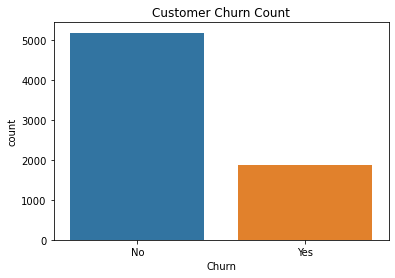

In [9]:
sns.countplot(x=telco_data['Churn'])
plt.title('Customer Churn Count')

In [10]:
labels = telco_data['Churn'].value_counts().index

fig = go.Figure(data=[go.Pie(labels=labels, values=telco_data['Churn'].value_counts())])
fig.show()

# Static pie chart
#plt.pie(telco_data['Churn'].value_counts(), autopct='%1.1f%%',labels=labels)
#plt.title('Customer Churn Rate')

**Insights**
- The dataset is imbalanced with more "No" label
- No = 73.5%, Yes = 26.5%; No = 3x Yes
- The churn rate is currently low (26.5%)

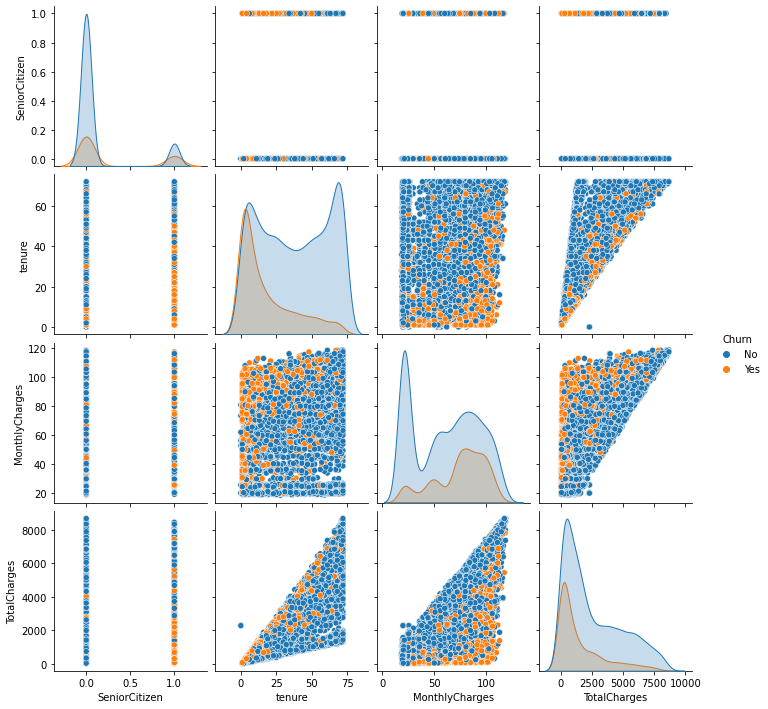

In [11]:
sns.pairplot(telco_data,hue='Churn')

There are only 4 numerical features to plot. We will look at count plots on all the categorical features to see their relation to churn rate

In [12]:
cat_features = telco_data.select_dtypes(include='object')
cat_features.head()

gender Partner Dependents PhoneService     MultipleLines InternetService  \
0  Female     Yes         No           No  No phone service             DSL   
1    Male      No         No          Yes                No             DSL   
2    Male      No         No          Yes                No             DSL   
3    Male      No         No           No  No phone service             DSL   
4  Female      No         No          Yes                No     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  \
0              No  Month-to-month              Yes           Electronic check   
1              No        One year               No               Mailed check   
2              No  Month-to-month              Yes               Mailed check   
3              No        One year               No  Bank transfer (automatic)   
4              No  Month-to-month              Yes           Electronic check   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

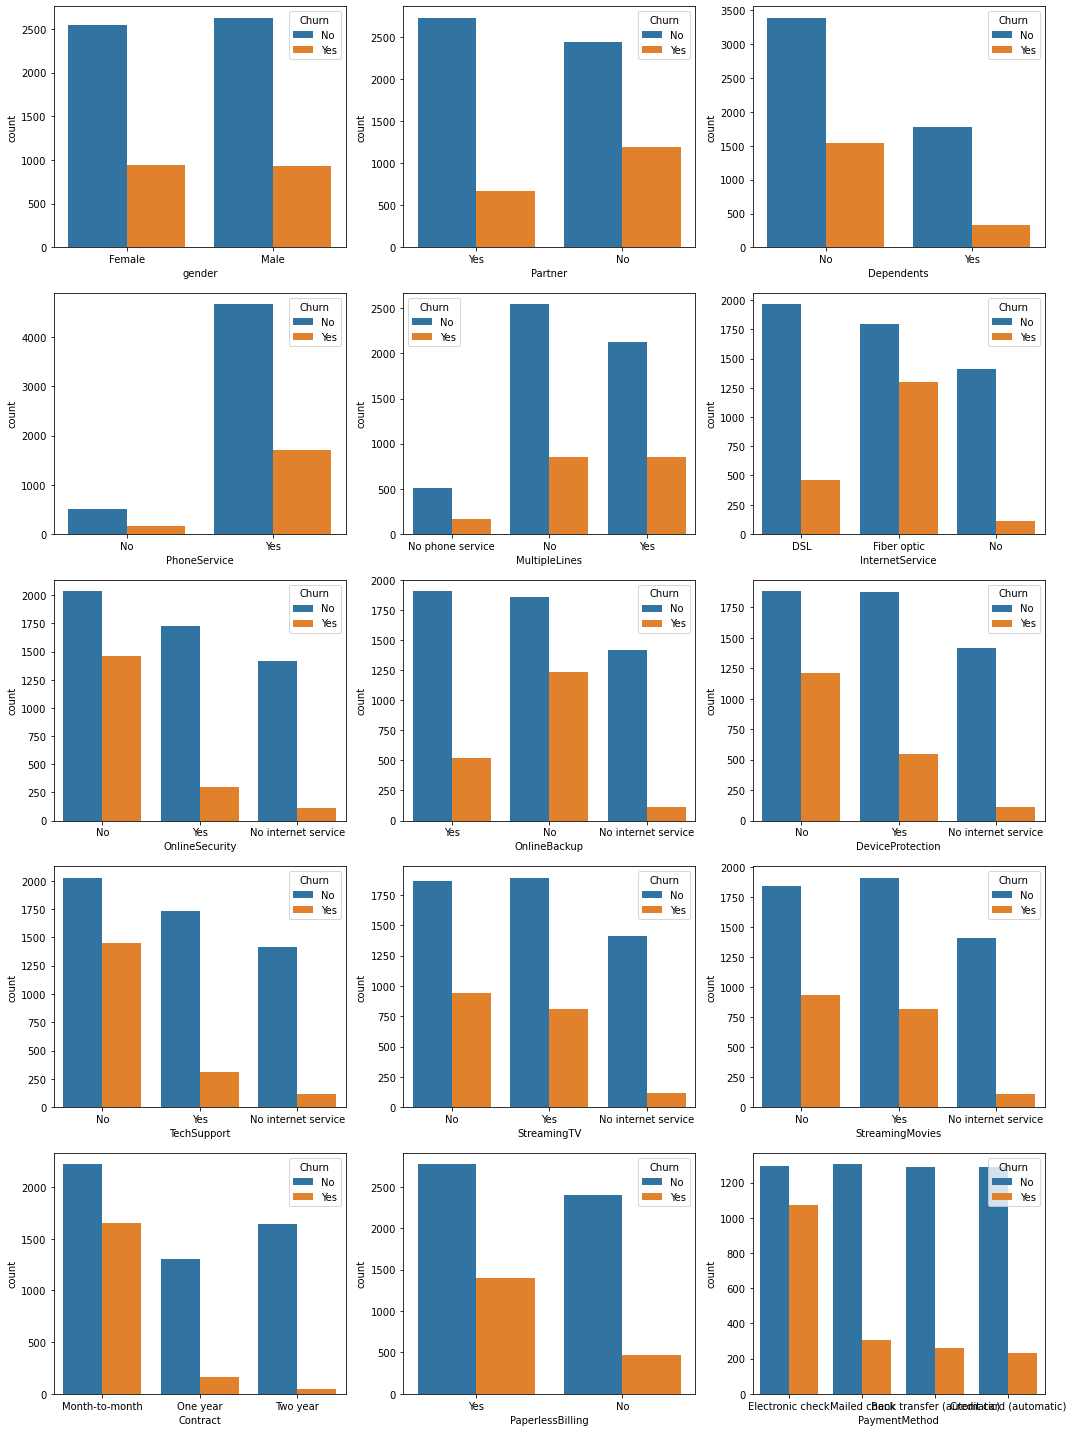

In [13]:
plt.figure(figsize=(15,20))

i=1
for col_name in cat_features.columns[0:15]: # exclude Churn from the cat_features at this moment
    plt.subplot(5,3,i)
    sns.countplot(x=telco_data[col_name],hue=telco_data['Churn'])
    i +=1
    plt.tight_layout()

In [14]:
# Simplify the "No internet service" response to "No"
Internet_cat = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

for cat in Internet_cat:
    telco_data[cat] = telco_data[cat].replace({"No internet service":"No"})
    
# MulitpleLines
telco_data['MultipleLines'] = telco_data['MultipleLines'].replace({"No phone service":"No"})

Take a look at the distribution of the 3 numerical data: tenure, monthly charges and total charges

Text(0, 0.5, 'Count')

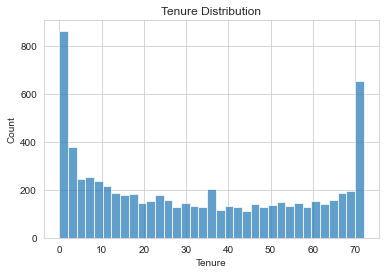

In [15]:
sns.set_style('whitegrid')
telco_data['tenure'].hist(bins=35,alpha=0.7)

plt.title("Tenure Distribution")
plt.xlabel("Tenure")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

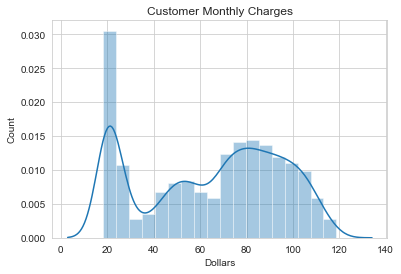

In [16]:
sns.distplot(telco_data['MonthlyCharges'],hist=True)

plt.title("Customer Monthly Charges")
plt.xlabel("Dollars")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

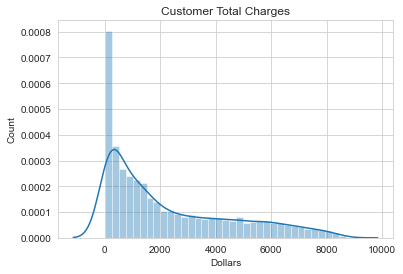

In [17]:
sns.distplot(telco_data['TotalCharges'],hist=True,bins=35)

plt.title("Customer Total Charges")
plt.xlabel("Dollars")
plt.ylabel("Count")

=> The Total charges distribuiton is skewed to the right.

### EDA Insights

* Churn rate is low for No-interenet-service feature
* Churn rate is significantly high for Month-to-month contract and Electronic-check payment method

## C. Data Preprocessing

## C1. Encoding categorical feature
### C1. a. Encoding the Dependent Variable (Churn): Label Encoder 

In [18]:
# Convert the target column Churn to a binary feature
# either using LabelEncoder or LabelBinarizer

# Yes (churn) is 1
# No Churn is 0

label_encd = LabelEncoder()
telco_data['Churn'] = label_encd.fit_transform(telco_data['Churn'])

### C1. b. Encoding the Independent Variable: One-hot Encoder 

In [19]:
# Convert the categorical features to dummy variables
cat_col = cat_features.drop('Churn',axis=1).columns.tolist()

telco_data_encd = pd.get_dummies(telco_data,prefix_sep="_",columns=cat_col,drop_first=True)
telco_data_encd.head()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0            0   
1              0      34           56.95       1889.50      0            1   
2              0       2           53.85        108.15      1            1   
3              0      45           42.30       1840.75      0            1   
4              0       2           70.70        151.65      1            0   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  MultipleLines_Yes  ...  \
0            1               0                 0                  0  ...   
1            0               0                 1                  0  ...   
2            0               0                 1                  0  ...   
3            0               0                 0                  0  ...   
4            0               0                 1                  0  ...   

   DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
0                     0                0                0   
1                     1                0                0   
2                     0                0                0   
3                     1                1                0   
4                     0                0                0   

   StreamingMovies_Yes  Contract_One year  Contract_Two year  \
0                    0                  0                  0   
1                    0                  1                  0   
2                    0                  0                  0   
3                    0                  1                  0   
4                    0                  0                  0   

   PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
0                     1                                      0   
1                     0                                      0   
2                     1                                      0   
3                     0                                      0   
4                     1                                      0   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  
0                               1                           0  
1                               0                           1  
2                               0                           1  
3                               0                           0  
4                               1                           0  

[5 rows x 24 columns]

In [20]:
telco_data_encd.head()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0            0   
1              0      34           56.95       1889.50      0            1   
2              0       2           53.85        108.15      1            1   
3              0      45           42.30       1840.75      0            1   
4              0       2           70.70        151.65      1            0   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  MultipleLines_Yes  ...  \
0            1               0                 0                  0  ...   
1            0               0                 1                  0  ...   
2            0               0                 1                  0  ...   
3            0               0                 0                  0  ...   
4            0               0                 1                  0  ...   

   DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
0                     0                0                0   
1                     1                0                0   
2                     0                0                0   
3                     1                1                0   
4                     0                0                0   

   StreamingMovies_Yes  Contract_One year  Contract_Two year  \
0                    0                  0                  0   
1                    0                  1                  0   
2                    0                  0                  0   
3                    0                  1                  0   
4                    0                  0                  0   

   PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
0                     1                                      0   
1                     0                                      0   
2                     1                                      0   
3                     0                                      0   
4                     1                                      0   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  
0                               1                           0  
1                               0                           1  
2                               0                           1  
3                               0                           0  
4                               1                           0  

[5 rows x 24 columns]

<AxesSubplot:>

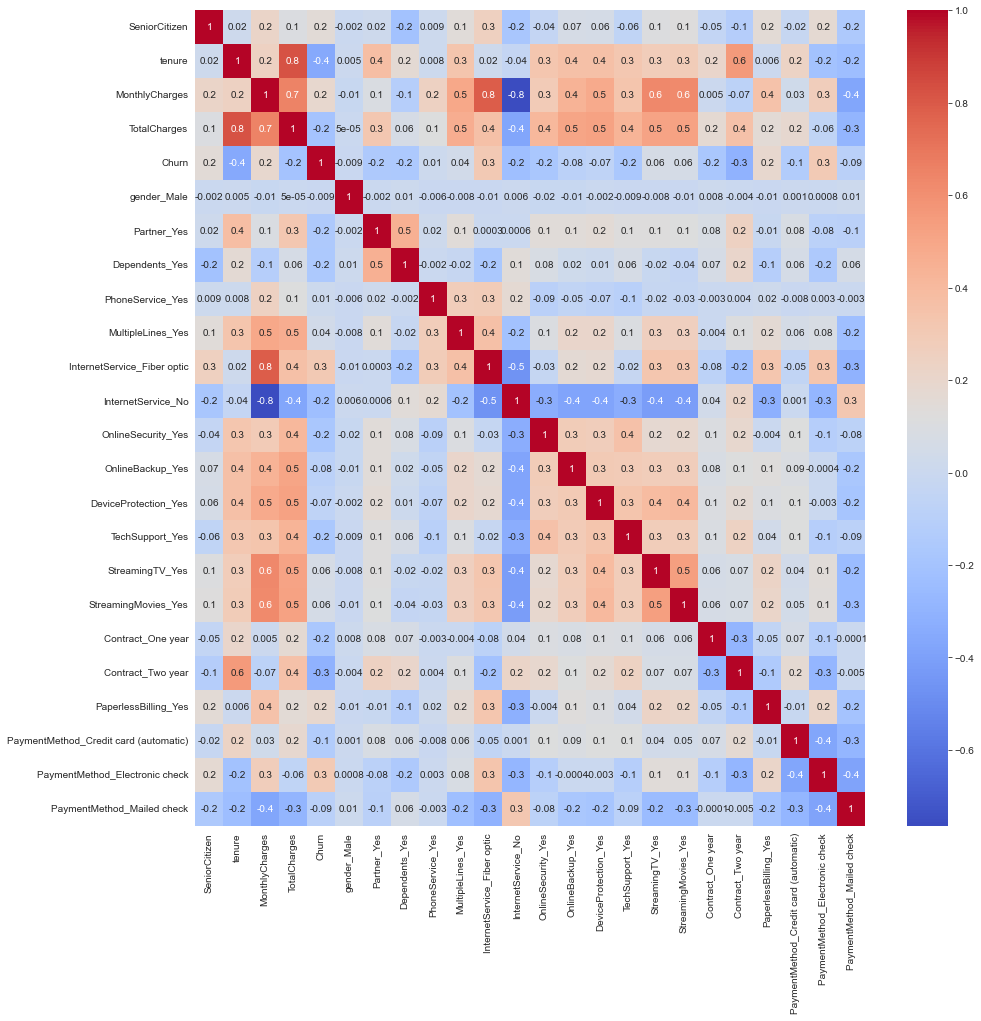

In [21]:
# Quick look at the current data set to gather some preliminary insights
plt.figure(figsize=(15,15))
sns.heatmap(telco_data_encd.corr(),annot=True, cmap='coolwarm',fmt='.1g')

In [22]:
# https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial

data = [go.Heatmap(
        z= telco_data_encd.corr().values,
        x=telco_data_encd.columns.values,
        y=telco_data_encd.columns.values,
        colorscale='RdBu_r',
        opacity = 1.0 )]

layout = go.Layout(
    title='Pearson Correlation of Input Features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
fig.show()

#### Insights:
Features that are highly correlated to Churn rate:
* Payment Method - Electronic Check, Internet Service - Fiber optic, Monthly Charges, Paperless Billing, Seniror Citizen

Features that contribute to high montly charges/total charges:
* Streaming TV and movies, Fiber optic, Online Backup, Device Protection

## D. Data Preparation
## D1. Train - Test Split

In [23]:
X = telco_data_encd.drop('Churn',axis=1)
y = telco_data_encd['Churn']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## D2. Feature Scaling

### D2. a. Check for skewnees

Earlier, we observed the feature `TotalCharges` is skewed to the right

#### Option 1: compared pvalue to alpha. Ho: the dataset is a normal distribution

In [25]:
from scipy.stats import shapiro

In [26]:
shapiro(telco_data['TotalCharges'])

ShapiroResult(statistic=0.8607502579689026, pvalue=0.0)

Here we reject Ho. This means Total Charges is not normally distributed

#### Option 2: Calculate skewness

In [27]:
num_features = telco_data[['tenure','MonthlyCharges','TotalCharges']]
num_features.head()

tenure  MonthlyCharges  TotalCharges
0       1           29.85         29.85
1      34           56.95       1889.50
2       2           53.85        108.15
3      45           42.30       1840.75
4       2           70.70        151.65

In [28]:
skew_features = num_features.skew().sort_values(ascending=False)
sknewness= pd.DataFrame({'Skew':skew_features})
sknewness

Skew
TotalCharges    0.962394
tenure          0.239540
MonthlyCharges -0.220524

**Insights**


=> Total Charges skewwess is moderately postive skewed: 0.5 < 0.96 < 1  
=> It is fine to **train the model with these features as they are**

---

Explore: what if I apply skewness transformation by using log transformation

In [29]:
# Try log transformation to see how it looks
log_TotalCharges = np.log(telco_data['TotalCharges'])

In [30]:
# It transformed the TotalCharges to moderately negative skewed
log_TotalCharges.skew()

-0.7558896276917938

Text(0, 0.5, 'Count')

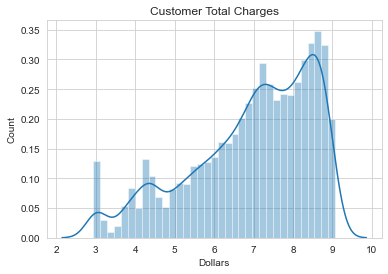

In [31]:
sns.distplot(log_TotalCharges,hist=True,bins=35)

plt.title("Customer Total Charges")
plt.xlabel("Dollars")
plt.ylabel("Count")

## E. Classification Models

Use the following models:
* Logistic Regression
* KNN
* Decision Tree
* Random Forest
* Support Vector Machine

**Deciding on important metrics for this analysis**

Firstly, we want to have a model with high accuracy predicting the customer churn rate.

Currently, 73.5% of customers is keeping the service. I want to retain customers retention program, thus I want to focus on correctly predicting customers who are likely to churn. Precision is the second important metric.

Assume that it is inexpensive to lose a customer, I want to give out promotions to those that predicted to churn. I will try to minimize the wrongly predicited no-churn customers (FN), a high Recall value is also a good metric. 


## E1. Hyper-Parameters Tuning 

For these two models, I will perform a grid search to find the optimal parameters (k for KNN; C and gamma for SVM)

Note: don't need to instantiate cross-validation/Kfold object for the tuning steps. It seems like the gridsearchCV has its own cv
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

### E1. a. For KNN

In [32]:
k_range = range(1,41)
param_grid_knn = dict(n_neighbors=k_range)

for k in k_range:
    grid_knn = GridSearchCV(KNeighborsClassifier(n_neighbors=k), param_grid_knn, cv=10,scoring='accuracy')

In [33]:
grid_knn.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=40),
             param_grid={'n_neighbors': range(1, 41)}, scoring='accuracy')

In [34]:
grid_knn.best_params_

{'n_neighbors': 29}

### E1. b. For SVM

In [35]:
param_grid={'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001]}

grid_svm = GridSearchCV(SVC(), param_grid, cv=10,scoring='accuracy')

In [36]:
grid_svm.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             scoring='accuracy')

In [37]:
grid_svm.best_params_

{'C': 1, 'gamma': 0.001}

## E2. Create the models
Use the tuned parameters

In [38]:
log = LogisticRegression().fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=29).fit(X_train, y_train)
tree = DecisionTreeClassifier().fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)
svc = SVC(C=1,gamma=0.001).fit(X_train, y_train)

In [39]:
models = [log, knn, tree, rfc, svc]
models_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Support Vector Machine']

## E3. Applying k-fold cross validation on the Train set

Apply 3 scoring metrics: accuracy, precision, and recall

In [41]:
scoring = ['accuracy','precision','recall']
xval_accuracy = []
xval_precision = []
xval_recall = []
xval_std = []

train_scoring = {}
for i,model in enumerate (models):
    scores = cross_validate(model, X_train, y_train, cv=10, scoring=scoring)
    
    # omit the first two columns from scoring which are fit_time and score_time
    xval_accuracy.append(scores['test_accuracy'].mean())
    xval_precision.append(scores['test_precision'].mean())
    xval_recall.append(scores['test_recall'].mean())
    xval_std.append(scores['test_accuracy'].std())
    
    # get accuracy scores for each fold (10 folds total) 
    train_scoring[i] = scores['test_accuracy'] # for graphing purpose below

In [42]:
xval_scores = pd.DataFrame(list(zip(xval_accuracy, xval_precision, xval_recall, xval_std)),
                            index=models_names, columns=['Accuracy','Precision','Recall','Standard Deviation'])
print('Models Training Scores')
xval_scores

Models Training Scores


Accuracy  Precision    Recall  Standard Deviation
Logistic Regression     0.804462   0.667043  0.515868            0.012899
KNN                     0.779716   0.658907  0.341330            0.019628
Decision Tree           0.721298   0.472285  0.491151            0.021355
Random Forest           0.788235   0.627045  0.482671            0.019982
Support Vector Machine  0.778296   0.625697  0.389195            0.015099

### E3. a. Compare the models' accuracy resulted from cross validation

Text(0, 0.5, 'Accuracy rate')

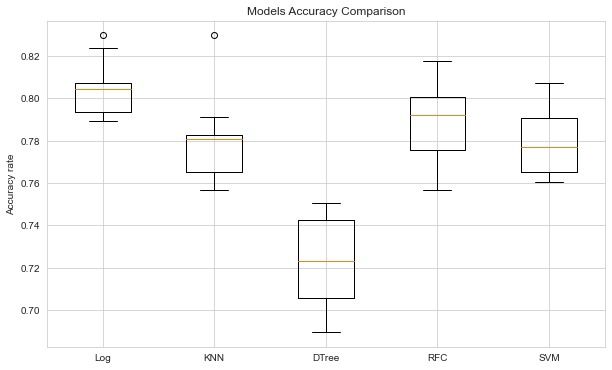

In [44]:
# https://stackoverflow.com/questions/52273543/creating-multiple-boxplots-on-the-same-graph-from-a-dictionary/52274064

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(train_scoring.values())
ax.set_xticklabels(['Log','KNN','DTree','RFC','SVM'])

plt.title('Models Accuracy Comparison')
plt.ylabel('Accuracy rate')

#### Insights
Logistic Regression model achieves simplicity and high scores in all the metrics from running cross validation on train set 

## F. Test the models on the Test set and Compare their performance
## F1. Confusion Matrix and Classification Report

In [53]:
def model_performance_report(models):
    """
    This function computes the confusion matrix and classification for the model. 
    The function summaries performance scores: accuracy, precision, recall, and error rate
    """
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    error_rate = []

    for i,model in enumerate (models):
        y_pred = model.predict(X_test)
        conf_matrix = confusion_matrix(y_test,y_pred)

        print('\n')
        print(models_names[i])
        print(classification_report(y_test,y_pred))
        '\n'
        print(conf_matrix)
        
        tn = conf_matrix[0,0]
        fp = conf_matrix[0,1]
        tp = conf_matrix[1,1]
        fn = conf_matrix[1,0]

        total = tn + fp + tp + fn

        accuracy  = (tp + tn) / total # Accuracy Rate
        precision = tp / (tp + fp) # Positive Predictive Value
        recall    = tp / (tp + fn) # True Positive Rate
        error = (fp + fn) / total # Missclassification Rate

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        error_rate.append(error)
    
    scores_df = pd.DataFrame(list(zip(accuracy_scores,precision_scores,recall_scores,error_rate)), 
                             index=models_names,columns=['Accuracy','Precision','Recall','Error Rate'])
    print('\n')
    print("Models Evaluation Scores Summary")
    return scores_df

In [54]:
model_performance_report(models)



Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1539
           1       0.69      0.55      0.61       574

    accuracy                           0.81      2113
   macro avg       0.77      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113

[[1397  142]
 [ 261  313]]


KNN
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1539
           1       0.70      0.37      0.49       574

    accuracy                           0.79      2113
   macro avg       0.75      0.66      0.68      2113
weighted avg       0.77      0.79      0.76      2113

[[1449   90]
 [ 360  214]]


Decision Tree
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1539
           1       0.52      0.50      0.51       574

    accuracy                           0.74      2113
   macro avg       0.67      0

Accuracy  Precision    Recall  Error Rate
Logistic Regression     0.809276   0.687912  0.545296    0.190724
KNN                     0.787033   0.703947  0.372822    0.212967
Decision Tree           0.739233   0.520947  0.498258    0.260767
Random Forest           0.792239   0.666667  0.470383    0.207761
Support Vector Machine  0.790345   0.696697  0.404181    0.209655

#### Insights:
Logistic Regression model still achieves high scores on all the chosen metrics when applying on the test set.

## F2. ROC and AUC

In [49]:
def plot_roc_auc(models, X_test, y_test):
    """
    Plots ROC curves and calculates AUC for multiple models.

    Parameters:
        models (list of sklearn models): List of trained machine learning models.
        X_test (array-like): Test data features.
        y_test (array-like): True labels for the test data.
        model_names (list of str): List of model names for labeling the curves.

    Returns:
        None (displays ROC curves and AUC values).
    """
    
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
  
    for model in models:
        display = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)

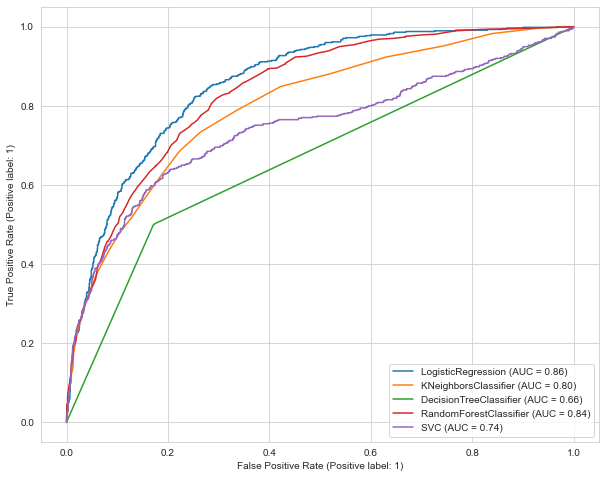

In [50]:
plot_roc_auc(models, X_test, y_test)

## F3. Conclusion

**Logistic Regression** is chosen as the predictive model for Customer Churn due to its good performance and simplicity

---

## G. Improve the Logistic Model 

## G1. Find the optimal threshold for the Logistic Regression model

Since the dataset is imbalanced, I'm using the precision-recall tradeoff curve to find the optimal threshold.<br>
Applying the logistic model on the train set for this purpose

In [93]:
y_train_pred = log.predict(X_train)
y_train_pred_proba = log.predict_proba(X_train)[:,1]

train_output = pd.DataFrame({'True Churned_Train': y_train.values, 
                             'Predict Probability_Train': y_train_pred_proba})

train_output.head()

True Churned_Train  Predict Probability_Train
0                   0                   0.064289
1                   0                   0.717831
2                   0                   0.077775
3                   0                   0.474115
4                   0                   0.598899

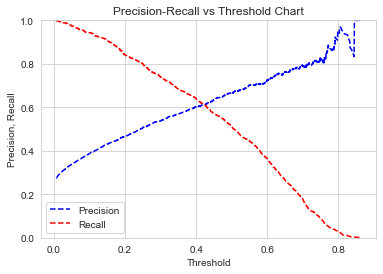

In [94]:
# Finding precision, recall, and thresholds arrays
p, r, thresholds = precision_recall_curve(train_output['True Churned_Train'], train_output['Predict Probability_Train'])
pr_auc = metrics.auc(r,p)

# Precison,recall vs Threshold chart
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, p[: -1], "b--", label="Precision")
plt.plot(thresholds, r[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1]);

Best Threshold=0.33, F-Score=0.627
Precision score = 0.72, Recall score = 0.56


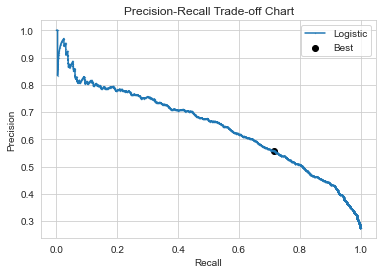

In [95]:
# f score
fscore = (2 * p * r) / (p + r)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.2f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Precision score = %.2f, Recall score = %.2f' %(r[ix], p[ix]))

# Precision vs Recall chart
plt.plot(r, p, marker='.', label='Logistic',markersize=0.5)
plt.scatter(r[ix], p[ix], marker='o', color='black', label='Best')

plt.title('Precision-Recall Trade-off Chart')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

The optimal threshold is **0.33**. Improve the logistic model by applying the threshold to classify the labels

## G2. Modify the Logistic Regression model with the threshold = 0.33

In [96]:
def get_predicted_values_w_threshold(X, y):
    y_pred = log.predict(X)
    y_pred_proba = log.predict_proba(X)[:,1]
    
    output = pd.DataFrame({'True Churned': y.values, 
                           'Predict Probability': y_pred_proba})
    output['Predict Churned'] = output['Predict Probability'].apply(lambda x: 1 if x > 0.31 else 0)
    
    return output

In [97]:
train_result = get_predicted_values_w_threshold(X_train, y_train)
test_result = get_predicted_values_w_threshold(X_test, y_test)

In [98]:
train_result.head()

True Churned  Predict Probability  Predict Churned
0             0             0.064289                0
1             0             0.717831                1
2             0             0.077775                0
3             0             0.474115                1
4             0             0.598899                1

In [88]:
def log_model_perform(y, y_pred, set_type):

    score = []

    conf_matrix = confusion_matrix(y, y_pred['Predict Churned'].values)
    print(classification_report(y, y_pred['Predict Churned'].values))
    '\n'
    print(conf_matrix)

    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]

    total = tn + fp + tp + fn
    accuracy  = (tp + tn) / total # Accuracy Rate
    precision = tp / (tp + fp) # Positive Predictive Value
    recall    = tp / (tp + fn) # True Positive Rate
    error = (fp + fn) / total # Missclassification Rate

    score.append(accuracy)
    score.append(precision)
    score.append(recall)

    scores = pd.DataFrame(score, columns=[set_type], index=['Accuracy','Precision','Recall'])
    return scores

In [89]:
log_model_perform(y_train, train_result, "Train Set")

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      3635
           1       0.55      0.73      0.62      1295

    accuracy                           0.77      4930
   macro avg       0.72      0.76      0.73      4930
weighted avg       0.80      0.77      0.78      4930

[[2853  782]
 [ 352  943]]


Train Set
Accuracy    0.769980
Precision   0.546667
Recall      0.728185

In [90]:
log_model_perform(y_test, test_result, "Test Set")

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1539
           1       0.57      0.76      0.65       574

    accuracy                           0.78      2113
   macro avg       0.74      0.77      0.75      2113
weighted avg       0.81      0.78      0.79      2113

[[1217  322]
 [ 140  434]]


Test Set
Accuracy   0.781354
Precision  0.574074
Recall     0.756098